MARCH 2019 JUST TRYING TO FINISH THIS PAPER!! GETTING FIGURES.

This is a simple attempt to find the time constant for appropriate deconvolution using the data from June 2017. 
The base code is based on TimeConstant, but the Model is going to be shifted to try to align the Model and the Data more. (the main one being the line up of the base at zero.)
Essentially the same just with the Model shifted.

Using the numbers from TimeConstant3 I will check to see the differences in the Model's convolved versus deconvolved spectrum.
I will then apply them to different runs. 

Mira



In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
#import emcee

In [15]:
with open('../../data/raw_data/20170615_1729_30mms_reference.pkl', 'rb') as f:
    d = pickle.load(f, encoding='latin1') 

30.0


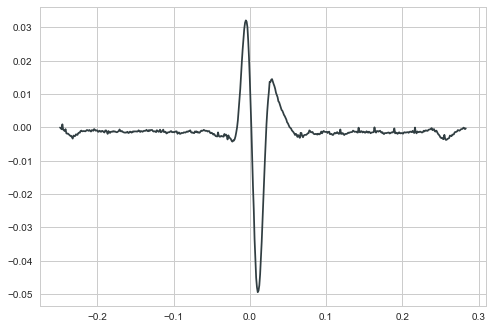

In [16]:
i = 9
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
print(v)
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0

startpt = int(startpt)
endpt = int(endpt)
F = (d['sig0F']) 
D = F[startpt:endpt]
#D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

pl.plot(t,D)
pl.show()

The shift was averaged to be around .00148. 
To get the bases to line up I will subtract this amount from the Model function. 

In [4]:
#model function convoluted with RC circuit and AC coupling function
def psi1(znot,q,p,T):
    Ns = Nsize
    z = t
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    y0=-np.cos(2*np.pi*q*(z-znot))*(np.exp(-((z-znot)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

In [5]:
#likelihood function
#why is it ln?
def lnlike(params, t, D):
    znot, q, p, T, a = params 
    t,Modelf = psi1(znot,q,p, T)
    Dev = -.5*(np.dot((D-(Modelf*a-.00148)),D-(Modelf*a-.00148)))
    Sig=0.0005
    return (Dev/Sig)-np.log(1/Sig) #sigma? if sigma is large it becomes shallower

In [6]:
nll = lambda *args: -lnlike(*args) 
result = op.minimize(nll, [.003,23.51,0.01335,0.0028, .00001], args=(t,D))
znot1,q1,p1,T1,a1 = result["x"]
print (result ["x"])

[  4.08108175e-03   1.97817009e+01   1.32568802e-02   5.80651456e-05
   1.32596391e-05]


/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys
/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


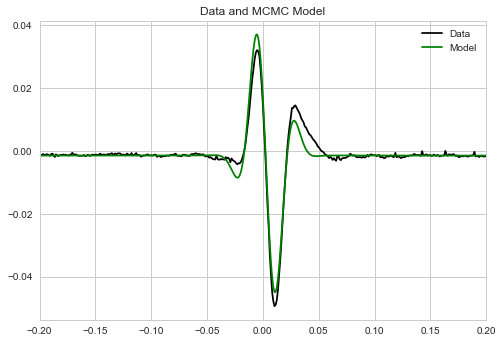

In [7]:
#using results gotten from optimization and the linear shift 
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1( 4.08117518e-03,   1.97816983e+01,   1.32568793e-02,   5.79709697e-05) #z,q,p,T

pl.plot(x,Modelf*1.32596339e-05-.00148, label = 'Model', color = 'green')
pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


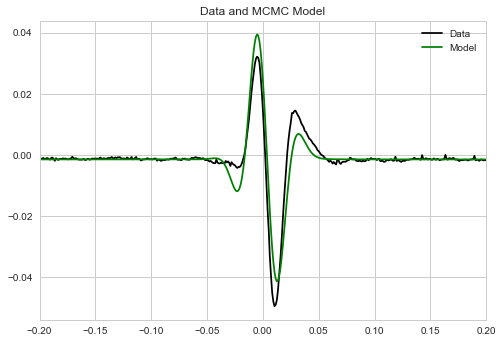

In [8]:
#plugging in the MEANS gotten from the MCMC 
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1( 0.000157881588507,   21.3790525768,   0.0146442984523,   .00795999628391) #z,q,p,T

pl.plot(x,Modelf*2.16095251255e-05-.00148, label = 'Model', color = 'green')
pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


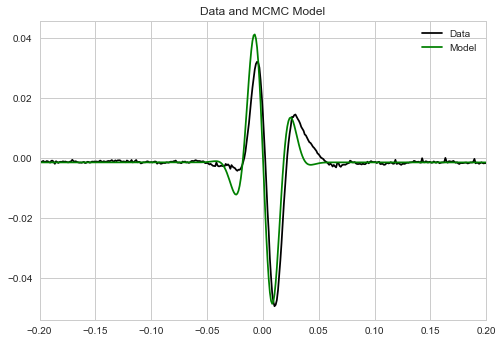

In [9]:
#plugging in the PEAKS gotten from the MCMC 
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1( 0.000157881588507,   22.5,   0.01399,   .00173) #z,q,p,T

pl.plot(x,Modelf*.000014-.00148, label = 'Model', color = 'green')
pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()

Using the numbers from the MCMC here I will deconvolve the Model function.
that is to say the time constant is set to .00173, the peak of the time constant.

The amplitudes have been adjusted to make the differences more clear.

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


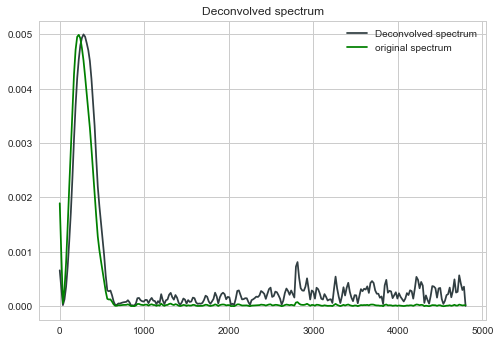

In [10]:
A = np.hanning(Nsize)*F[startpt:endpt]
S = np.fft.rfft(A)
s = S[:-1]
u = np.abs(s)
dNu = 1/(Nsize*dx)
Nu = dNu*np.arange(Nsize/2)
NuFull = dNu*np.arange((Nsize/2) + 1)
center = (300*(Nu[0] + Nu[-1]))/2
top = max(np.abs(s))
tau = 0.0017 #ms
k_v = 1/((1/tau)+1j*2*np.pi*300*NuFull)
            
            
n = 3 #greater number filters out more high frequencies
sig = n/(tau*(2*np.pi)) 
f = (1/(sig*np.sqrt(np.pi)))*np.exp(-(NuFull**2)/(sig**2)) #gaussian
B = f*np.fft.rfft(A)/k_v*tau  #fourier transform of interferogram/kernel
c = np.fft.irfft(B) #inverse fourier transform of deconvolved spectrum (deconvolved interferogram)
            
# normalize gaussian to get rid of noise (divide by integral of itself) (in B)
            
g = (np.abs(np.fft.rfft(c))/k_v*tau)[:2**7] #CHANGE depending on number of data points
L=np.sum(g) #integral of spectrum
            
xint, yint = t, (1/L)*c
xspec, yspec = 300*NuFull, np.abs(np.fft.rfft(c))/k_v*tau
yspecnoabs = np.fft.rfft(c)/k_v*tau
pl.plot(xspec,yspec, label = 'Deconvolved spectrum')
pl.plot(300*NuFull,np.abs(S)*.00575, label = 'original spectrum', color = 'green')
pl.title('Deconvolved spectrum')
pl.legend()
pl.show()

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


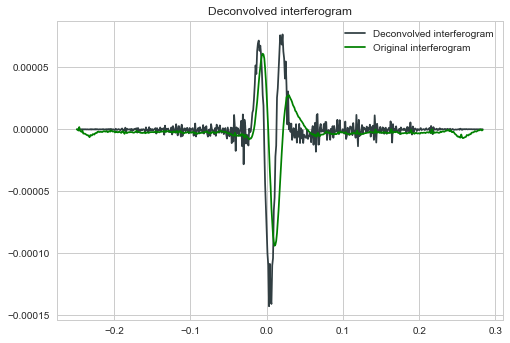

In [11]:
pl.plot(xint,yint, label = 'Deconvolved interferogram')
pl.plot(t,D*.0019, label = 'Original interferogram', color = 'green')
pl.title('Deconvolved interferogram')
#pl.vlines(-.02,-.00015,.00005)
#pl.vlines(.03,-.00015,.00005)
#pl.vlines(-.06,-.00015,.00005)
#pl.vlines(.07,-.00015,.00005)
pl.legend()

10.0
3586.5
3798.5
-0.155402563653
99
-0.290997
212


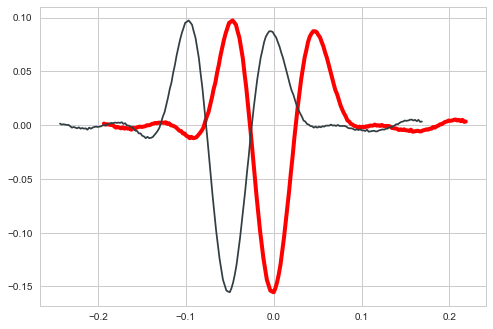

In [17]:
#20170615_1729_30mms_reference.pkl
with open('../../data/raw_data/20180411_1941_filter_measurements_reference_bandpass_filter.pkl', 'rb') as f:
    d = pickle.load(f, encoding='latin1') 
    
i = 9
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
print(v)
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize-300#ending point
print(startpt)
print(endpt)

df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0

startpt = int(startpt)
endpt = int(endpt)
F = (d['sig0F']) 
D2 = F[startpt:endpt]
#D = np.flipud(D)
a = d['delay0F']/v
t2 = a[startpt:endpt] 
D2 = list(D2)
print(min(D2))
print(D2.index(min(D2)))
print(t2[D2.index(min(D2))])
t3 = np.array(t2 - t2[D2.index(min(D2))])
D2 = np.array(D2)
print(len(t2))

pl.plot(t3,D2,linewidth = 4,color = 'red')
pl.plot(t3-.05,D2)
pl.show()

/Users/Lab/anaconda/envs/py3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


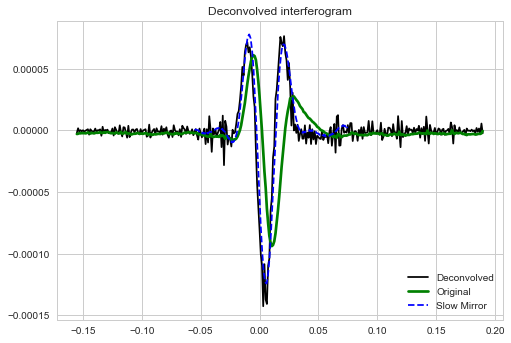

In [13]:
t3 = np.linspace(-.055,.075,212)
pl.plot(xint[90:-90],yint[90:-90], label = 'Deconvolved',color = 'black')
pl.plot(t[90:-90],D[90:-90]*.0019, linewidth = 2.7,label = 'Original', color = 'green')
pl.plot(t3,D2*.0008,linestyle = '--',label = 'Slow Mirror',color = 'blue')
pl.title('Deconvolved interferogram')
pl.legend(loc = 'lower right')
#pl.savefig('DeconvolvedInterferograms.png',dpi = 1000)
pl.show()